In [1]:
import json

from matplotlib import pyplot as plt
import pandas as pd
import pickle
from s3fs.core import S3FileSystem

In [2]:
MODEL_DIR = "mids-capstone-irrigation-detection/models"

In [3]:
s3_file = S3FileSystem()

# Models are model_name: description
models = {
    "supervised_baseline": "Balanced Dataset",
    "supervised_baseline_ex": "Balanced Extended Labels",
    "supervised_baseline_pretrained": "ImageNet Pretraining",
    "supervised_baseline_pretrained_ex": "ImageNet Pretraining with Extended Labels"
}

In [4]:
def f_scores(scores):
    precision = scores[6]
    recall = scores[7]
    if precision + recall == 0.0:
        return [0.0, 0.0]
    f1 = (2 * precision * recall) / (precision + recall)
    beta = 0.5
    f05 = ((1 + beta) * precision * recall) / (beta * precision + recall)
    return [f1, f05]
    

In [5]:
def load_results():
    data = []
    for file in s3_file.listdir(MODEL_DIR):
        if file['type'] != 'directory':
            continue
        model_type = file["name"].split("/")[-1]
        for result in s3_file.glob(file["name"]+"/*.json"):
            model_type = result.split("/")[-2]
            percent = result.split("/")[-1].split("_")[0]
            day = result.split("/")[-1].split("-")[-1].split(".")[0]
            r = json.load(s3_file.open(result))
            score = [model_type, int(percent), r.get("pretrain", False), r["architecture"]] + r["score"] + f_scores(r["score"])
            data.append(score)
    df = pd.DataFrame(data)
    df.columns = ["model_type", "split_percent","pretrain", "architecture","loss","tp","fp","tn","fn","accuracy","precision","recall","auc","f1","f0.5"]
    df.split_percent = pd.to_numeric(df.split_percent, errors='coerce')
    return df

def plot_results(plot_df, title=None):
    _title = "Accuracy vs Data Splits"
    if title is not None:
        _title += f" - {title}"
    plot_df.plot(kind="bar", figsize=(15,10), rot=0, ylim=(0.0, 1.0), fontsize=14)
    plt.title(_title, fontsize=22)
    plt.legend(fontsize=12)
    plt.xlabel("Percent Labeled Data", fontsize=18)
    plt.ylabel("Accuracy", fontsize=18)
    
def convert_to_plot(df):
    plot_df = df[["accuracy", "architecture", "split_percent"]]
    plot_df = plot_df.pivot(
        index="split_percent", 
        columns="architecture", 
        values="accuracy"
    ).sort_values("split_percent", ascending=False)
    return plot_df

def display_results():
    df = load_results()
    for model_type, desc in models.items():
        _df = df[df.model_type == model_type]
        
        line = "=" * len(desc) + "=="
        print(f"\n\n{line}\n {desc}\n{line}")
        display(_df.sort_values("split_percent"))

        plot_df = convert_to_plot(_df)
        display(plot_df)
        plot_results(plot_df, desc)
        plt.savefig(f"{model_type}.png")



 Balanced Dataset


,model_type,split_percent,pretrain,architecture,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
14,supervised_baseline,1,False,Xception,0.889790,0.0,0.0,1999.0,2001.0,0.499750,0.000000,0.000000,0.500000,0.000000,0.000000
13,supervised_baseline,1,False,ResNet50,15.399220,253.0,166.0,1836.0,1745.0,0.522250,0.603819,0.126627,0.586941,0.209350,0.267630
12,supervised_baseline,1,False,ResNet152,0.455079,1349.0,221.0,1809.0,685.0,0.777067,0.859236,0.663225,0.902077,0.748613,0.782180
10,supervised_baseline,1,False,InceptionV3,1.047916,1959.0,1685.0,313.0,43.0,0.568000,0.537596,0.978521,0.835938,0.693943,0.632616
11,supervised_baseline,1,False,ResNet101V2,6.496781,146.0,49.0,1951.0,1854.0,0.524250,0.748718,0.073000,0.762576,0.133030,0.183264
22,supervised_baseline,3,False,ResNet152,0.439815,1425.0,162.0,1871.0,606.0,0.811024,0.897921,0.701625,0.919590,0.787728,0.821326
20,supervised_baseline,3,False,InceptionV3,0.404579,1644.0,247.0,1757.0,352.0,0.850250,0.869381,0.823647,0.927201,0.845897,0.853583
23,supervised_baseline,3,False,ResNet50,0.642376,1973.0,894.0,1111.0,22.0,0.771000,0.688176,0.988972,0.912204,0.811600,0.765817
24,supervised_baseline,3,False,Xception,0.569571,703.0,62.0,1934.0,1301.0,0.659250,0.918954,0.350798,0.894042,0.507765,0.596774
21,supervised_baseline,3,False,ResNet101V2,0.381174,1687.0,349.0,1651.0,313.0,0.834500,0.828585,0.843500,0.910095,0.835976,0.833498


architecture,InceptionV3,ResNet101V2,ResNet152,ResNet50,Xception
split_percent,,,,,
100,0.93925,0.93450,0.915600,0.93275,0.93975
50,0.93550,0.90925,0.936516,0.90650,0.93875
25,0.89875,0.92050,0.907726,0.91900,0.92925
10,0.78500,0.89825,0.885581,0.82050,0.89625
3,0.85025,0.83450,0.811024,0.77100,0.65925
1,0.56800,0.52425,0.777067,0.52225,0.49975




 Balanced Extended Labels


,model_type,split_percent,pretrain,architecture,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
44,supervised_baseline_ex,1,False,Xception,0.636070,5487.0,4087.0,1397.0,5.0,0.627187,0.573115,0.999090,0.869907,0.728395,0.668060
43,supervised_baseline_ex,1,False,ResNet50,0.639899,5488.0,4832.0,651.0,5.0,0.559311,0.531783,0.999090,0.875725,0.694112,0.630008
42,supervised_baseline_ex,1,False,ResNet152,0.965505,5484.0,4889.0,601.0,2.0,0.554391,0.528680,0.999635,0.868902,0.691595,0.627173
40,supervised_baseline_ex,1,False,InceptionV3,0.465399,5022.0,1674.0,3814.0,466.0,0.805029,0.750000,0.915087,0.886435,0.824360,0.797987
41,supervised_baseline_ex,1,False,ResNet101V2,0.608232,4620.0,1232.0,4255.0,869.0,0.808582,0.789474,0.841683,0.869314,0.814743,0.806142
52,supervised_baseline_ex,3,False,ResNet152,0.467159,4758.0,1443.0,4043.0,732.0,0.801840,0.767296,0.866667,0.870558,0.813959,0.797787
50,supervised_baseline_ex,3,False,InceptionV3,0.398222,4634.0,1081.0,4411.0,850.0,0.824071,0.810849,0.845004,0.901977,0.827574,0.821923
53,supervised_baseline_ex,3,False,ResNet50,0.376675,4863.0,1223.0,4268.0,622.0,0.831906,0.799047,0.886600,0.908497,0.840550,0.826245
54,supervised_baseline_ex,3,False,Xception,0.379902,4563.0,935.0,4551.0,927.0,0.830357,0.829938,0.831148,0.910119,0.830542,0.830341
51,supervised_baseline_ex,3,False,ResNet101V2,0.412007,4443.0,957.0,4529.0,1047.0,0.817420,0.822778,0.809290,0.897231,0.815978,0.818232


architecture,InceptionV3,ResNet101V2,ResNet152,ResNet50,Xception
split_percent,,,,,
100,0.888028,0.856050,0.871538,0.859056,0.885477
50,0.873269,0.819424,0.836826,0.863794,0.847577
25,0.850856,0.837008,0.851130,0.847303,0.840835
10,0.835550,0.847030,0.842839,0.813138,0.844479
3,0.824071,0.817420,0.801840,0.831906,0.830357
1,0.805029,0.808582,0.554391,0.559311,0.627187




 ImageNet Pretraining


,model_type,split_percent,pretrain,architecture,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
74,supervised_baseline_pretrained,1,True,Xception,0.853724,1777.0,477.0,1526.0,220.0,0.825750,0.788376,0.889835,0.888382,0.836039,0.819523
73,supervised_baseline_pretrained,1,True,ResNet50,0.899088,1658.0,593.0,1407.0,342.0,0.766250,0.736562,0.829000,0.832000,0.780052,0.764995
72,supervised_baseline_pretrained,1,True,ResNet152,1.299277,1111.0,278.0,1753.0,922.0,0.704724,0.799856,0.546483,0.804429,0.649328,0.692787
70,supervised_baseline_pretrained,1,True,InceptionV3,0.762314,1787.0,663.0,1328.0,222.0,0.778750,0.729388,0.889497,0.865381,0.801525,0.775944
71,supervised_baseline_pretrained,1,True,ResNet101V2,1.948836,1609.0,488.0,1517.0,386.0,0.781500,0.767287,0.806516,0.841302,0.786413,0.779932
82,supervised_baseline_pretrained,3,True,ResNet152,0.645926,1506.0,446.0,1586.0,526.0,0.760827,0.771516,0.741142,0.843999,0.756024,0.761119
80,supervised_baseline_pretrained,3,True,InceptionV3,0.814511,1708.0,438.0,1559.0,295.0,0.816750,0.795899,0.852721,0.875010,0.823331,0.813979
83,supervised_baseline_pretrained,3,True,ResNet50,0.530867,1674.0,566.0,1430.0,330.0,0.776000,0.747321,0.835329,0.852625,0.788878,0.774522
84,supervised_baseline_pretrained,3,True,Xception,0.839364,1707.0,324.0,1678.0,291.0,0.846250,0.840473,0.854354,0.904083,0.847357,0.845050
81,supervised_baseline_pretrained,3,True,ResNet101V2,2.740340,1724.0,352.0,1646.0,278.0,0.842500,0.830443,0.861139,0.870926,0.845513,0.840429


architecture,InceptionV3,ResNet101V2,ResNet152,ResNet50,Xception
split_percent,,,,,
100,0.85600,0.88225,0.816929,0.82875,0.89575
50,0.85425,0.88475,0.790600,0.81050,0.88525
25,0.84125,0.85025,0.789616,0.81700,0.87650
10,0.82425,0.73550,0.725640,0.78925,0.83625
3,0.81675,0.84250,0.760827,0.77600,0.84625
1,0.77875,0.78150,0.704724,0.76625,0.82575




 ImageNet Pretraining with Extended Labels


,model_type,split_percent,pretrain,architecture,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
104,supervised_baseline_pretrained_ex,1,True,Xception,0.702423,4676.0,1559.0,3930.0,811.0,0.784074,0.749960,0.852196,0.860060,0.797816,0.781200
103,supervised_baseline_pretrained_ex,1,True,ResNet50,1.768483,3488.0,1101.0,4387.0,2000.0,0.717474,0.760078,0.635568,0.789121,0.692270,0.713487
102,supervised_baseline_pretrained_ex,1,True,ResNet152,1.025812,4166.0,1561.0,3929.0,1320.0,0.737518,0.727431,0.759388,0.802667,0.743066,0.737780
100,supervised_baseline_pretrained_ex,1,True,InceptionV3,0.678098,4616.0,1573.0,3916.0,871.0,0.777332,0.745839,0.841261,0.845379,0.790682,0.775147
101,supervised_baseline_pretrained_ex,1,True,ResNet101V2,1.936698,4768.0,1813.0,3674.0,721.0,0.769133,0.724510,0.868646,0.821128,0.790058,0.766929
112,supervised_baseline_pretrained_ex,3,True,ResNet152,0.785645,4385.0,1617.0,3872.0,1102.0,0.752278,0.730590,0.799162,0.824855,0.763339,0.752101
110,supervised_baseline_pretrained_ex,3,True,InceptionV3,0.545311,5179.0,2528.0,2958.0,311.0,0.741345,0.671987,0.943352,0.853063,0.784875,0.743255
113,supervised_baseline_pretrained_ex,3,True,ResNet50,0.619915,3208.0,790.0,4699.0,2279.0,0.720390,0.802401,0.584655,0.827004,0.676436,0.713788
114,supervised_baseline_pretrained_ex,3,True,Xception,0.453389,4509.0,1146.0,4340.0,981.0,0.806214,0.797347,0.821311,0.881145,0.809152,0.805179
111,supervised_baseline_pretrained_ex,3,True,ResNet101V2,0.997767,4247.0,1162.0,4322.0,1245.0,0.780703,0.785173,0.773307,0.855530,0.779195,0.781177


architecture,InceptionV3,ResNet101V2,ResNet152,ResNet50,Xception
split_percent,,,,,
100,0.821793,0.846028,0.792821,0.793003,0.845117
50,0.811224,0.834001,0.784803,0.794734,0.845208
25,0.802660,0.829173,0.775237,0.763575,0.828626
10,0.743349,0.783710,0.754100,0.760933,0.822522
3,0.741345,0.780703,0.752278,0.720390,0.806214
1,0.777332,0.769133,0.737518,0.717474,0.784074


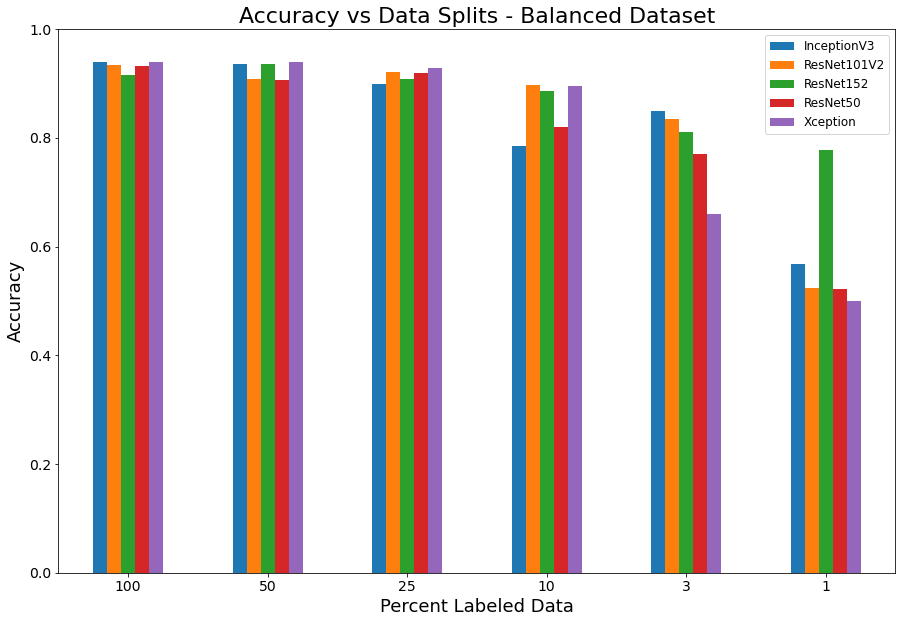

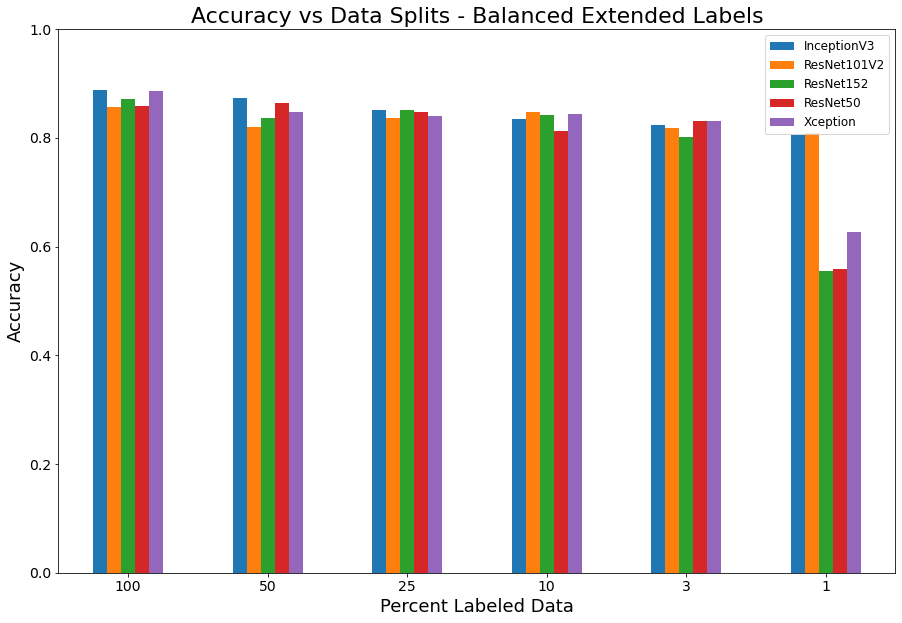

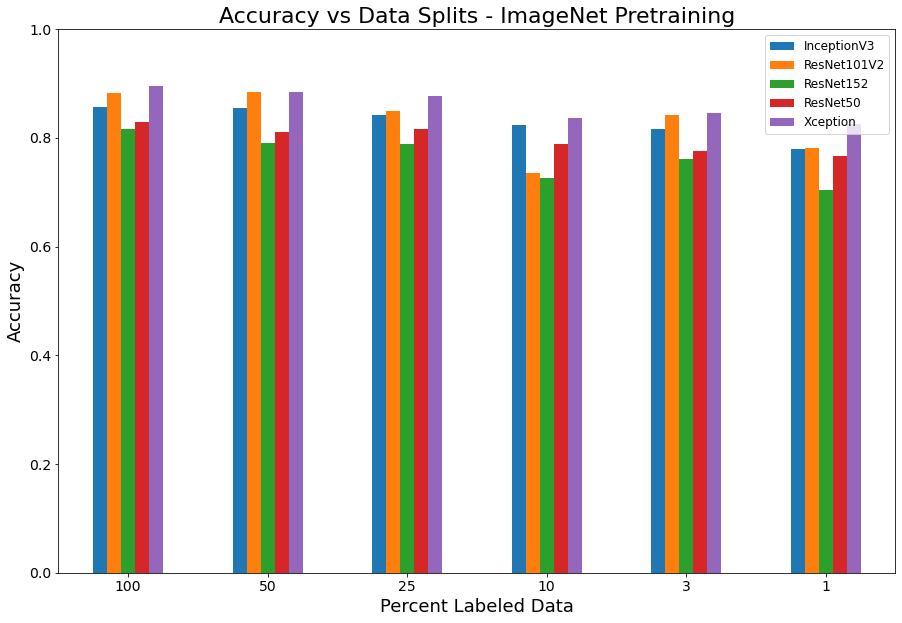

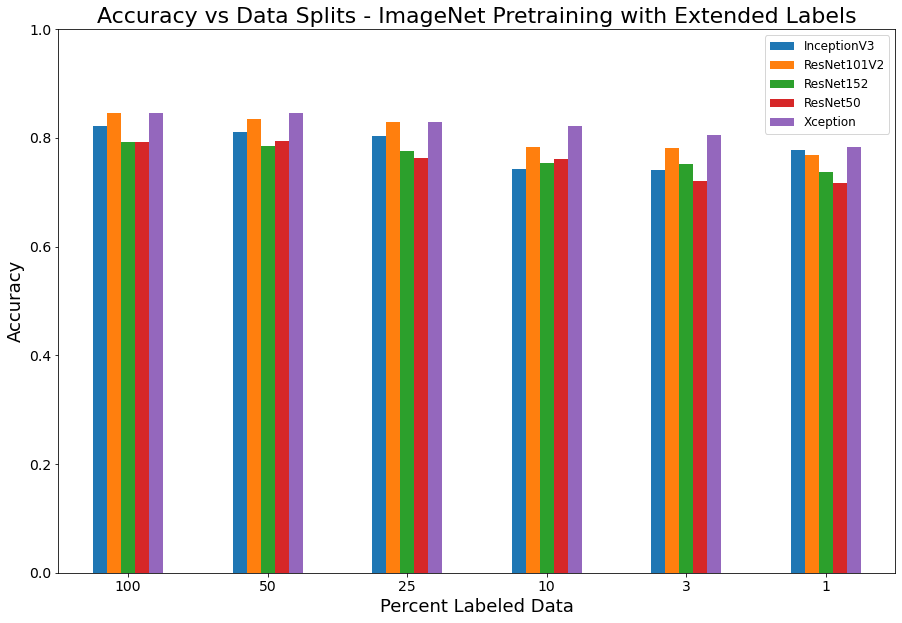

In [6]:
 display_results()